In [1]:
import sys
sys.path.append("../script/")

from sklearn.metrics import classification_report,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
import Functions
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from time import time
from Node import Node

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# Engine

In [4]:
class Engine:
    def __init__(self,opset,X,Y,residual,log_odds,p,learning_rate,max_depth):
        self.generation = 0
        
        X = X.astype('float64')
        self.opset = opset
        
        self.feature_space = X.shape[1]
        
        self.vals = X.T
        self.X = X
        self.Y = Y

        self.residual = residual
        self.log_odds = log_odds
        self.p = p
        self.sample_weights = np.sum(np.abs(np.array(residual)),axis=1)
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        
        self.best = (np.inf,None)
        self.nodes = [Node(True,index=i) for i in range(self.feature_space)]
    
    
    def calculate_decision(self,val):

        clf = DecisionTreeClassifier(max_depth=self.max_depth)
        clf.fit(val,self.Y,sample_weight=self.sample_weights)
        
        bins = len(clf.tree_.threshold)
        index = clf.apply(val)
        
        residual_bin = np.stack([np.sum(self.residual[index==i],axis=0) for i in range(bins)])
        p_bin = np.stack([np.sum(np.multiply(self.p[index==i],1-self.p[index==i]),axis=0) for i in range(bins)])

        # grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))
        addon = 1/val.shape[0]
        p_bin[p_bin < addon] = addon
        grad_bin = np.divide(residual_bin,p_bin) #TO-DO is 1e-5 enough?

        loss = -np.sum(clf.tree_.n_node_samples@np.abs(grad_bin))

        return loss,clf,(bins,grad_bin)
    
    def calculate_fitness(self,vals,beta):
        fitness = []
        clfs = []
        for val in vals:
            loss,clf,clf_param = self.calculate_decision(np.array([val]).T)
            
            fitness.append(loss)
            clfs.append((clf,clf_param))

        return fitness,clfs
    

    def evolve(self,total_size,batch_size,elite_size,beta,verbose):
        self.generation += 1
        
        if verbose:
            print("\tgeneration:",self.generation)
            t = time()
        
        num_batches = total_size//batch_size
        pool = self.nodes

        elites = []
        elites_fitness = []
        for j in range(num_batches):

            funcs = np.random.choice(list(self.opset.keys()),size=batch_size)
            arg_count = [self.opset[func] for func in funcs]
            sons = np.random.choice(pool,size = sum(arg_count))
            it = iter(sons)
            sons = [[next(it) for _ in range(arg_count[i])] for i in range(batch_size)]
            vals = [funcs[i]([self.vals[s.index] for s in sons[i]]) for i in range(batch_size)]

            vals = np.stack(vals)
            fitness,clfs = self.calculate_fitness(vals,beta)
            
            elites.extend([(funcs[i],sons[i],vals[i],clfs[i]) for i in range(batch_size)])
            elites_fitness.extend(fitness)

            rank = np.argsort(elites_fitness)

            elits = [elites[index] for index in rank[:elite_size]]
            elites_fitness = [elites_fitness[index] for index in rank[:elite_size]]

        for index in range(elite_size):
            func,son,val,clf = elits[index]

            node = Node(False,
                func=func,
                sons=son,
                index=len(self.nodes),
                fit=elites_fitness[index]
            )
            node.clf = clf

            if index == 0:
                if self.best[0] > node.fitness:
                    self.best = (node.fitness,node)
            self.nodes.append(node)
            self.vals = np.append(self.vals,[val],axis=0)
            self.test_param_same(node)
      

        if verbose:
            print("\t",np.max(elites_fitness))
            print("\ttime",time()-t)
        return None

    def test_param_same(self,node):
        v1 = node.predict(self.X)
        v2 = self.vals[node.index]
        if np.any(v1!=v2):
            print(node.index,v1==v2)

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# Stack

In [6]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [7]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/(y_one_hot.shape[0] - np.sum(y_one_hot,axis=0))
    init_log_odds = np.array(np.log(init_log_odds))

    init_p = np.exp(init_log_odds)
    init_p = np.array(init_p/(1+init_p))

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p

def gradient(node,val):
    val = np.array([val]).T

    clf,clf_param = node.clf
    bins,grad_bin = clf_param
    index = clf.apply(val)

    grads = np.zeros((val.shape[0],grad_bin.shape[1]))
    for i in range(bins):
        grads[index==i] = grad_bin[i]
        
    return grads

def update_log_p(grads,log_odds,p,mask,learning_rate):
    log_odds_1 = log_odds + grads * learning_rate
    # log_odds_1 = log_odds + mask.reshape(-1,1)*grads * learning_rate
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 1024,out=np.zeros(log_odds_1.shape)+1024)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 1024,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict_single_node(node,X,log_odds,p,learning_rate):
    mask = np.sum(np.power(p,2),axis=1) < 1

    val = node.predict(X)
    grads = gradient(node,val)
    
    log_odds,p = update_log_p(grads,log_odds,p,mask,learning_rate)

    return log_odds,p

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        log_odds,p = predict_single_node(node,X,log_odds,p,learning_rate) 
        
    return p

# Data

## Small datasets

In [8]:
# ref from 2segp github
# Classification dataset names - choose from following datasets 

CLASS_DATASET_NAMES = ['bcw','heart','iono','parks','sonar']
dataset_name = CLASS_DATASET_NAMES[1]


# Load the dataset
Xy = np.genfromtxt('test_data/'+dataset_name+'.csv', delimiter=',')
X = Xy[:, :-1]
y = Xy[:, -1]   # last column is the label

# simple operators

boost_num = 1000

seed = np.random.randint(9999999)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

## Cover Type

In [8]:
df = pd.read_csv('../data/covtype.data',header=None)
data_X = df.iloc[:,:-1].to_numpy()
data_y = df.iloc[:,-1].to_numpy().astype('int')


In [9]:
X_train,X_test,y_train,y_test = train_test_split(data_X,data_y,test_size=0.9)
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

## Higgs

In [10]:
df = pd.read_csv('../data/HIGGS.csv',header=None)
data_X = df.iloc[:,1:].to_numpy()
data_y = df.iloc[:,0].to_numpy().astype('int')

In [11]:
X_train,X_test2,y_train,y_test2 = train_test_split(data_X,data_y,test_size=500000)
Xs,ys = shuffle(X_train,y_train)

In [12]:
i = 105000
j = 10500

X_train = Xs[:i]
y_train = ys[:i]

X_test = Xs[i:i+j]
y_test = ys[i:i+j]

# Model

In [9]:
def train_engine(eg):
    log_odds = eg.log_odds
    p = eg.p
    residual = eg.residual
    learning_rate = eg.learning_rate

    #masking
    mask = np.sum(np.power(p,2),axis=1) < 1
#     mask = np.array(residual).T[0] > 0.1
                
    for j in range(1):
            eg.evolve(1,1,1,[0,0,0],0)
    
    node = eg.best[1]
    val = eg.vals[node.index]
    grads = gradient(node,val)
    log_odds,p = update_log_p(grads,log_odds,p,mask,learning_rate)


    # masked_grads = np.zeros(log_odds.shape)
    # masked_grads[mask] = grads_slim
    # log_odds,p = update_log_p(masked_grads,log_odds,p,mask,learning_rate)

    return node,val,log_odds,p,residual

In [10]:
def update_engine(X,y,log_odds,p,residual,learning_rate,max_depth,prev_eg=None):
    # eg = Engine(Functions.simple_opset,
    #             X[mask],
    #             y[mask],
    #             residual[mask],
    #             log_odds[mask],
    #             p[mask],
    #             learning_rate,max_depth)
    
    if prev_eg == None:
        eg = Engine(Functions.simple_opset,
            X,
            y,
            residual,
            log_odds,
            p,
            learning_rate,max_depth)
    else:
        eg = prev_eg
        
        eg.residual = residual
        eg.log_odds = log_odds
        eg.p = p
        eg.learning_rate = learning_rate
        eg.max_depth = max_depth

        eg.best = (np.inf,None)

    return eg

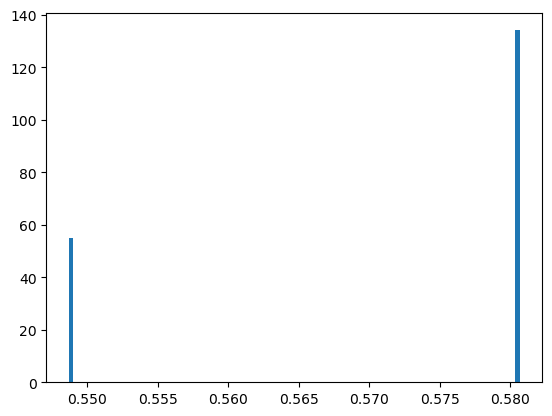

Generation: 0 91.06132731676777 40.34354421186808 0.5714285714285714 0.5185185185185185 0.001s
Generation: 1 89.10675884435514 39.969417167531816 0.5714285714285714 0.5185185185185185 0.001s
Generation: 2 87.90376441534202 39.60670988741836 0.5714285714285714 0.5185185185185185 0.0s
Generation: 3 87.17490500059954 39.38629057410538 0.6137566137566137 0.5432098765432098 0.001s
Generation: 4 86.69213861356742 39.321096540752734 0.6137566137566137 0.5432098765432098 0.001s
Generation: 5 86.42167849582188 39.44570583520013 0.6137566137566137 0.5432098765432098 0.001s
Generation: 6 85.15877746877923 39.34843141488412 0.6190476190476191 0.5432098765432098 0.0s
Generation: 7 85.15885092758045 39.3488171372568 0.6190476190476191 0.5432098765432098 0.001s
Generation: 8 84.75414395484822 39.1627297505931 0.6190476190476191 0.5432098765432098 0.001s
Generation: 9 84.75420962270425 39.16306760659383 0.6190476190476191 0.5432098765432098 0.001s
Generation: 10 84.15467483097719 39.05694839007597 0.6

In [13]:
stack = []
learning_rate = 0.1
max_depth = 1

train_acc = []
test_acc = []

y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
residual = y_train_one_hot - p

test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)
test_residual = y_test_one_hot - test_p

for g in range(1000):
    if g % 10 == 0:
        eg = update_engine(X_train,y_train,log_odds,p,residual,learning_rate,max_depth)
    else:
        eg = update_engine(X_train,y_train,log_odds,p,residual,learning_rate,max_depth,eg)

    start = time()
    node,val,log_odds,p,residual = train_engine(eg)
    training_time = time() - start
    
    residual = y_train_one_hot - p
    loss = np.sum(np.power(residual,2))

    if not np.isnan(loss):
        stack.append(node)

        if g % 1000 == 0:
            #residual plot
            plt.hist(np.max(p,axis=1),bins=100)
            plt.show()
            
        # train_acc.append(loss)
        # test_acc.append(test_loss)
        
        pred = np.argmax(p,axis=1)
        train_acc.append(accuracy_score(y_train,pred))
        # pred = p[:,1]
        # train_acc.append(roc_auc_score(y_train,pred))


        # test data prediction
        test_log_odds,test_p = predict_single_node(node,X_test,test_log_odds,test_p,learning_rate)
        test_residual = y_test_one_hot - test_p
        test_loss = np.sum(np.power(test_residual,2))

        
        # test_pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
        test_pred = np.argmax(test_p,axis=1)
        test_acc.append(accuracy_score(y_test,test_pred))
        # test_pred = test_p[:,1]
        # test_acc.append(roc_auc_score(y_test,test_pred))
    
        # print("Generation:",g,loss,train_acc[-1],str(round(training_time,3))+'s')
        print("Generation:",g,loss,test_loss,train_acc[-1],test_acc[-1],str(round(training_time,3))+'s')
    else:
        break

In [70]:
pd.value_counts([node.depth for node in stack])

1    2093
2    1498
3    1017
4     521
5     232
6      69
7      15
8       4
9       1
dtype: int64

In [71]:
pd.value_counts([node.numNode for node in stack])

3     2093
5     1336
7      864
9      511
11     294
13     149
15     105
17      41
19      30
23       7
21       7
25       7
27       2
29       2
31       1
33       1
dtype: int64

In [72]:
np.average([node.depth for node in stack[:130]]),np.average([node.depth for node in stack[130:]])

(2.0, 2.196240601503759)

In [73]:
np.average([node.numNode for node in stack[:130]]),np.average([node.numNode for node in stack[130:]])

(5.507692307692308, 5.932706766917293)

In [76]:
print(classification_report(y_train, np.argmax(p,axis=1)))
# print(roc_auc_score(y_train,p[:,1]))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     21477
           1       0.93      0.94      0.93     28054
           2       0.98      0.98      0.98      3626
           3       1.00      1.00      1.00       267
           4       0.99      0.87      0.92       909
           5       0.98      0.98      0.98      1724
           6       0.99      0.97      0.98      2044

    accuracy                           0.93     58101
   macro avg       0.97      0.95      0.96     58101
weighted avg       0.93      0.93      0.93     58101



In [77]:
print(classification_report(y_test, np.argmax(test_p,axis=1)))
# print(roc_auc_score(y_test,test_p[:,1]))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79    190363
           1       0.82      0.85      0.84    255247
           2       0.81      0.86      0.84     32128
           3       0.85      0.67      0.75      2480
           4       0.77      0.41      0.54      8584
           5       0.73      0.65      0.68     15643
           6       0.90      0.79      0.84     18466

    accuracy                           0.81    522911
   macro avg       0.81      0.72      0.75    522911
weighted avg       0.81      0.81      0.81    522911



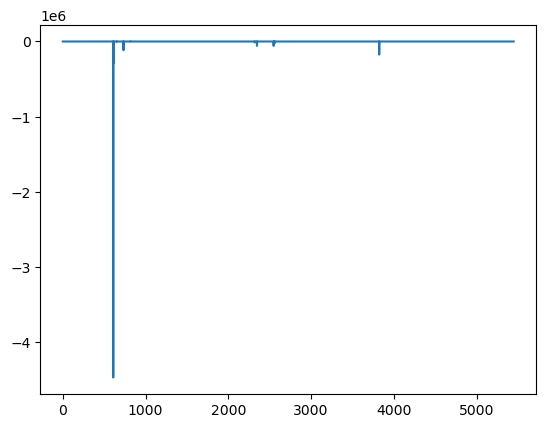

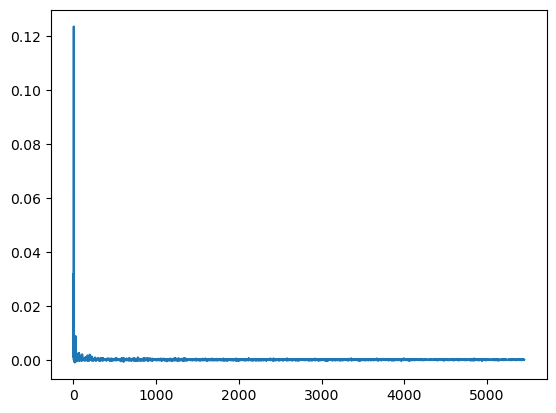

In [78]:
from sklearn.preprocessing import minmax_scale
acc = np.array(train_acc)

# w = [np.sum(np.abs(grad_bin)) for node,node_param,grad_bin in stack[:i]]
w = [np.sum(node.clf[1][1]) for node in stack]
# w = [0]
# for node in stack:
#     w.append(w[-1]+np.sum(node.clf[1][1]))

# w = minmax_scale(w)
# m = minmax_scale(acc[1:i+1]-acc[:i])
m = acc[:i]
plt.plot(w)
# plt.xscale('log')
plt.show()
plt.plot(m[1:]-m[:-1])
plt.show()

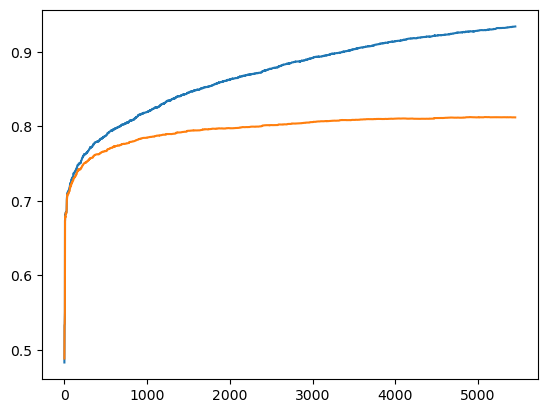

In [79]:
plt.plot(train_acc)
plt.plot(test_acc)

# XGboost

In [80]:
import xgboost

In [81]:
xgb = xgboost.XGBClassifier(n_estimators=100)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [83]:
pred = xgb.predict_proba(X_train)

pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred,digits=3))

pred = xgb.predict_proba(X_train)
pred = pred[:,1]
# print(roc_auc_score(y_train,pred))

pred = xgb.predict_proba(X_test)

pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred,digits=3))

pred = xgb.predict_proba(X_test)
pred = pred[:,1]
# print(roc_auc_score(y_test,pred))

              precision    recall  f1-score   support

           0      0.886     0.868     0.877     21477
           1      0.891     0.913     0.902     28054
           2      0.970     0.972     0.971      3626
           3      1.000     1.000     1.000       267
           4      0.968     0.738     0.838       909
           5      0.958     0.948     0.953      1724
           6      0.989     0.977     0.983      2044

    accuracy                          0.901     58101
   macro avg      0.952     0.917     0.932     58101
weighted avg      0.902     0.901     0.901     58101

              precision    recall  f1-score   support

           0      0.838     0.829     0.833    190363
           1      0.853     0.879     0.866    255247
           2      0.861     0.886     0.873     32128
           3      0.884     0.746     0.809      2480
           4      0.847     0.477     0.611      8584
           5      0.789     0.738     0.763     15643
           6      0.929 

In [84]:
xgb.get_booster().trees_to_dataframe()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,f0,3023.5,0-1,0-2,0-1,12462.416000,14228.817400,NaN
1,0,1,0-1,f0,2787.5,0-3,0-4,0-3,1230.060670,7725.796390,NaN
2,0,2,0-2,f0,3065.5,0-5,0-6,0-5,494.205078,6503.021000,NaN
3,0,3,0-3,f5,2835.5,0-7,0-8,0-7,97.239136,3257.387940,NaN
4,0,4,0-4,f3,92.5,0-9,0-10,0-9,515.172363,4468.408690,NaN
...,...,...,...,...,...,...,...,...,...,...,...
43615,699,98,699-98,Leaf,NaN,NaN,NaN,NaN,0.146271,9.169310,NaN
43616,699,99,699-99,Leaf,NaN,NaN,NaN,NaN,-0.079653,8.600679,NaN
43617,699,100,699-100,Leaf,NaN,NaN,NaN,NaN,0.094662,1.463033,NaN
43618,699,101,699-101,Leaf,NaN,NaN,NaN,NaN,0.058399,13.785927,NaN


# Gradient Boosting

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
clf = GradientBoostingClassifier(n_estimators=1000).fit(X_train, y_train)

In [21]:
pred = clf.predict_proba(X_train)
pred = pred[:,1]
print(roc_auc_score(y_train,pred))

ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
pred = clf.predict_proba(X_test)
pred = pred[:,1]
print(roc_auc_score(y_test,pred))

In [25]:
pred = clf.predict(X_train)
print(classification_report(y_train,pred,digits=3))

              precision    recall  f1-score   support

           0      0.875     0.856     0.866     21421
           1      0.882     0.907     0.894     28284
           2      0.967     0.954     0.961      3542
           3      1.000     1.000     1.000       278
           4      0.975     0.798     0.878       878
           5      0.944     0.910     0.927      1671
           6      0.982     0.932     0.956      2027

    accuracy                          0.891     58101
   macro avg      0.946     0.908     0.926     58101
weighted avg      0.892     0.891     0.891     58101



In [26]:
pred = clf.predict(X_test)
print(classification_report(y_test,pred,digits=3))

              precision    recall  f1-score   support

           0      0.830     0.818     0.824    190419
           1      0.843     0.874     0.858    255017
           2      0.847     0.864     0.855     32212
           3      0.823     0.740     0.779      2469
           4      0.810     0.475     0.599      8615
           5      0.755     0.687     0.719     15696
           6      0.909     0.813     0.858     18483

    accuracy                          0.838    522911
   macro avg      0.831     0.753     0.785    522911
weighted avg      0.838     0.838     0.837    522911



In [ ]:
w = [0]

for e in clf.estimators_:
    a = e[0]
    w.append(w[-1] + np.sum(a.tree_.value))

In [ ]:
plt.plot(w)

# Result

## CoverType

# Higgs

In [ ]:
pd.value_counts([node.depth for node in stack])

1     10474
2     10162
3      9116
4      7430
5      5444
6      3623
7      2027
8      1045
9       455
10      147
11       56
12       15
13        2
14        2
15        2
dtype: int64

In [ ]:
pd.value_counts([node.numNode for node in stack])

3      10474
5       8779
7       6702
9       5288
11      3927
13      3066
15      2501
17      1975
19      1586
21      1180
23       935
25       768
27       592
29       443
31       330
33       276
35       209
37       178
39       146
41       110
43        96
45        76
47        73
49        62
51        41
53        39
55        38
57        25
65        15
59        11
63        10
61         8
67         6
77         6
71         6
79         4
83         3
87         3
73         3
107        2
95         1
105        1
97         1
69         1
85         1
109        1
75         1
111        1
dtype: int64

In [ ]:
np.average([node.depth for node in stack[:1000]]),np.average([node.depth for node in stack[1000:]])

(2.495, 3.3331224489795916)

In [ ]:
np.average([node.numNode for node in stack[:1000]]),np.average([node.numNode for node in stack[1000:]])

(7.56, 10.449551020408164)

In [ ]:
test_pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
# test_pred = np.argmax(test_pred,axis=1)
# print(classification_report(y_test,test_pred))

test_pred = test_pred[:,1]
print(roc_auc_score(y_test,test_pred))

0.7862846424520893


In [ ]:
pred = predict(X_train,init_log_odds,init_p,learning_rate,stack)
# print(classification_report(y_train,pred))
pred = pred[:,1]
print(roc_auc_score(y_train,pred))

pred = predict(X_test,init_log_odds,init_p,learning_rate,stack)
# pred = np.argmax(pred,axis=1)
# print(classification_report(y_test,pred))

pred = pred[:,1]
print(roc_auc_score(y_test,pred))

In [ ]:
from sklearn.preprocessing import minmax_scale
acc = np.array(train_acc)

# w = [np.sum(np.abs(grad_bin)) for node,node_param,grad_bin in stack[:i]]
w = [np.sum(node.clf[1][1]) for node in stack]
# w = [0]
# for node in stack:
#     w.append(w[-1]+np.sum(node.clf[1][1]))

# w = minmax_scale(w)
# m = minmax_scale(acc[1:i+1]-acc[:i])
m = acc[:i]
plt.plot(w)
# plt.xscale('log')
plt.show()
plt.plot(m[1:]-m[:-1])
plt.show()

In [ ]:
plt.plot(train_acc)
plt.plot(test_acc)